# Beating the betting firms with linear models

* **Data Source:** [https://www.kaggle.com/hugomathien/soccer](https://www.kaggle.com/hugomathien/soccer)
* **Author:** Anders Munk-Nielsen

**Result:** It is possible to do better than the professional betting firms in terms of predicting each outcome (although they may be maximizing profit rather than trying to predict outcomes). This is using a linear model, and it requires us to use a lot of variables, though. 

**Perspectives:** We can only model 1(win), but there are *three* outcomes: Lose, Draw, and Win. 

In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
# Read
d = pd.read_csv('football_probs.csv')

# Data types 
d.date = pd.to_datetime(d.date)
cols_to_cat = ['league', 'season', 'team', 'country']
for c in cols_to_cat: 
    d[c] = d[c].astype('category')

Visualizing the home field advantage. 

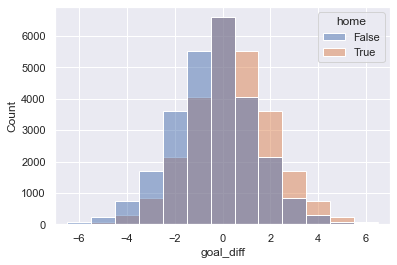

In [3]:
sns.histplot(data=d, x='goal_diff', hue='home', discrete=True); 
plt.xlim([-7,7]); 

Outcome variables

In [4]:
# Lose, Draw, Win 
d['outcome'] = 'L'
d.loc[d.goal_diff == 0.0, 'outcome'] = 'D'
d.loc[d.goal_diff >  0.0, 'outcome'] = 'W'

# Win dummy (as float (will become useful later))
d['win'] = (d.goal_diff > 0.0).astype(float)

# Odds to probabilities

### Convenient lists of variable names

* `cols_common`: All variables that are unrelated to betting 
* `betting_firms`: The prefix that defines the name of the betting firms, e.g. B365 for Bet365
* `firm_vars`: A dictionary returning the variables for a firm, e.g. `firm_vars['BW']` returns `BWA`, `BWD`, `BWH` (for Away, Draw, Home team win). 

In [5]:
# # List of the names of all firms that we have betting prices for
betting_firms = np.unique([c[:-4] for c in d.columns if c[-1] in ['A', 'H', 'D']])
betting_firms

# find all columns in our dataframe that are *not* betting variables 
cols_common = [c for c in d.columns if (c[-4:-1] != '_Pr') & (c[-9:] != 'overround')]
print(f'Non-odds variables: {cols_common}')

Non-odds variables: ['season', 'stage', 'date', 'match_api_id', 'team_api_id', 'goal', 'enemy_team_api_id', 'enemy_goal', 'home', 'goal_diff', 'league', 'country', 'team', 'enemy_team', 'outcome', 'win']


In [6]:
d[d.home].groupby('win')['B365_PrW'].mean().to_frame('Bet 365 Pr(win)')

,Bet 365 Pr(win)
win,
0.0,0.390852
1.0,0.520811


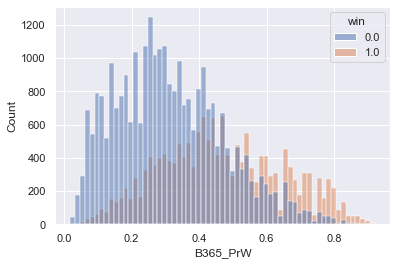

In [7]:
sns.histplot(d, x='B365_PrW', hue='win'); 

## Is there more information in the mean? 

If all firms are drawing random IID signals, then the average prediction should be a better estimator than any individual predictor. 

In [8]:
firms_drop = ['BS', 'GB', 'PS', 'SJ'] # these are missing in too many years 
cols_prW = [f'{c}_PrW' for c in betting_firms if c not in firms_drop]

In [9]:
d['avg_PrW'] = d[cols_prW].mean(1)
cols_prW += ['avg_PrW']

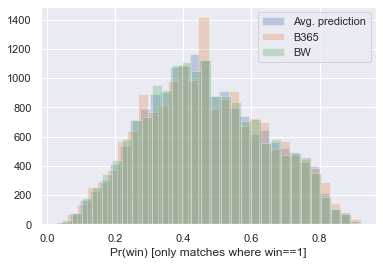

In [10]:
I = d.win == True
fig, ax = plt.subplots(); 
ax.hist(d.loc[I,'avg_PrW'], bins=30, alpha=0.3, label='Avg. prediction')
ax.hist(d.loc[I,'B365_PrW'], bins=30, alpha=0.3, label='B365')
ax.hist(d.loc[I,'BW_PrW'], bins=30, alpha=0.3, label='BW')
ax.legend(); 
ax.set_xlabel('Pr(win) [only matches where win==1]'); 

### RMSE comparison

* RMSE: Root Mean Squared Error. Whenever we have a candidate prediction guess, $\hat{y}_i$, we can evaluate $$ RMSE = \sqrt{ N^{-1}\sum_{i=1}^N (y_i - \hat{y}_i)^2 }. $$ 

In [11]:
def RMSE(yhat, y) -> float: 
    '''Root mean squared error: between yvar and y'''
    q = (yhat - y)**2
    return np.sqrt(np.mean(q))

In [12]:
def RMSE_agg(data: pd.core.frame.DataFrame, y: str) -> pd.core.series.Series: 
    '''RMSE_agg: Aggregates all columns, computing RMSE against the variable y for each column 
    '''
    assert y in data.columns
    
    y = data['win']
    
    # local function computing RMSE for a specific column, yvar, against y 
    def RMSE_(yhat): 
        diff_sq = (yhat - y) ** 2 
        return np.sqrt(np.mean(diff_sq))
    
    # do not compute RMSE against the real outcome :) 
    mycols = [c for c in data.columns if c != 'win']
    
    # return aggregated dataframe (which becomes a pandas series)
    return data[mycols].agg(RMSE_)

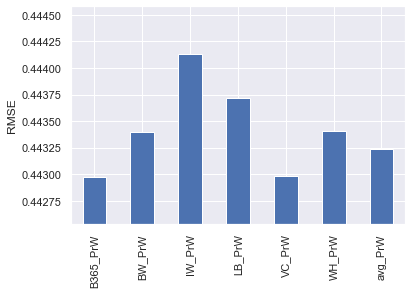

In [13]:
I = d[cols_prW].notnull().all(1) # only run comparison on subsample where all odds were observed 
x_ = RMSE_agg(d[cols_prW + ['win']], 'win');
ax = x_.plot.bar(); 
ax.set_ylim([x_.min()*.999, x_.max()*1.001]); 
ax.set_ylabel('RMSE'); 

# Linear Probability Models

Estimate a bunch of models where $y_i = 1(\text{win})$. 

## Using `numpy` 

In [14]:
d['home_'] = d.home.astype(float)

In [15]:
I = d[['home_', 'win'] + cols_prW].notnull().all(axis=1)
X = d.loc[I, ['home_'] + cols_prW].values
y = d.loc[I, 'win'].values.reshape(-1,1)

N = I.sum()
oo = np.ones((N,1))
X = np.hstack([oo, X])

In [16]:
betahat = np.linalg.inv(X.T @ X) @ X.T @ y

In [17]:
pd.DataFrame({'beta':betahat.flatten()}, index=['const', 'home'] + cols_prW)

,beta
const,0.098236
home,-0.017540
B365_PrW,0.953051
BW_PrW,0.058996
IW_PrW,-0.026695
LB_PrW,-0.455217
VC_PrW,1.044038
WH_PrW,0.236429
avg_PrW,-0.648330


## Using `statsmodels` 

(Cheating, but faster...) 

In [18]:
reg_addition = ' + '.join(cols_prW)
model_string = f'win ~ {reg_addition} + home + team'

In [19]:
cols_all = cols_prW + ['win', 'home']
I = d[cols_all].notnull().all(1) # no missings in any variables used in the prediction model 

Itrain   = I & (d.date <  '2015-01-01') # for estimating our prediction model 
Iholdout = I & (d.date >= '2015-01-01') # for assessing the model fit 

In [20]:
# run regression 
r = smf.ols(model_string, d[Itrain]).fit()
yhat = r.predict(d[I]).to_frame('AMN_PrW')
d.loc[I, 'AMN_PrW'] = yhat 

print('Estimates with Team FE')
r.params.loc[['home[T.True]'] + cols_prW].to_frame('Beta')

Estimates with Team FE


,Beta
home[T.True],0.018753
B365_PrW,0.716589
BW_PrW,-0.196396
IW_PrW,-0.224437
LB_PrW,-0.603811
VC_PrW,0.879185
WH_PrW,0.235899
avg_PrW,0.134505


### Plot estimates, $\hat{\beta}$

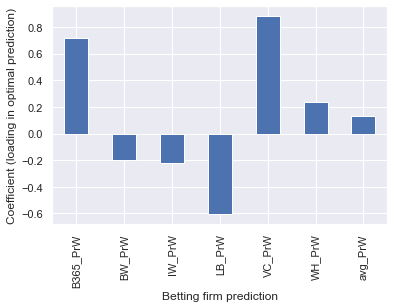

In [21]:
ax = r.params.loc[cols_prW].plot.bar();
ax.set_ylabel('Coefficient (loading in optimal prediction)'); 
ax.set_xlabel('Betting firm prediction'); 

### Plot model fit out of sample: avg. 1(win) vs. avg. $\hat{y}$ 

In [22]:
# predicted win rates from all firms and our new predicted probability 
cols = cols_prW + ['AMN_PrW'] 

**Home matches:** `home == True`

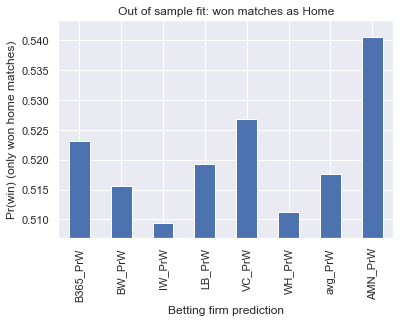

In [23]:
x_ = d.loc[(d.win == 1.0) & (d.home == True) & (Iholdout == True), cols].mean()
ax = x_.plot(kind='bar'); 
ax.set_ylim([x_.min()*0.995, x_.max()*1.005]); 
ax.set_title('Out of sample fit: won matches as Home'); 
ax.set_xlabel('Betting firm prediction'); 
ax.set_ylabel('Pr(win) (only won home matches)'); 

**Away matches:** `home == False`

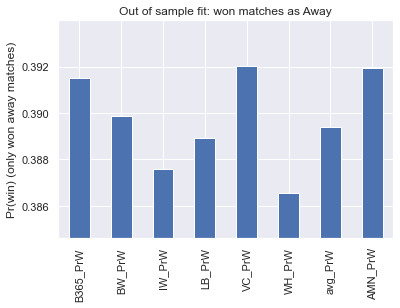

In [24]:
x_ = d.loc[(d.win == 1.0) & (d.home == False) & (Iholdout == True), cols].mean()
ax = x_.plot(kind='bar'); 
ax.set_ylim([x_.min()*0.995, x_.max()*1.005]); 
ax.set_ylabel('Pr(win) (only won away matches)'); 
ax.set_title('Out of sample fit: won matches as Away'); 

### RMSE 
(evaluated in the holdout sample, of course.)

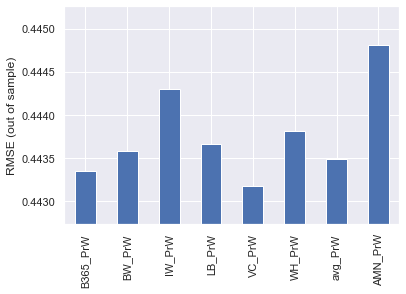

In [25]:
cols_ = cols_prW + ['AMN_PrW', 'win']
I = Iholdout & d[cols_].notnull().all(1) # only run comparison on subsample where all odds were observed 
x_ = RMSE_agg(d.loc[I,cols_], y='win');
ax = x_.plot.bar(); 
ax.set_ylim([x_.min()*.999, x_.max()*1.001]); 
ax.set_ylabel('RMSE (out of sample)'); 